**извлечение признаков из текста на естественном языке**

классификатор текстов SnowballStemmer+TfidfVectorizer

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
2618,"В прошлом году социологи и лауреат Нобелевской премии Ангус Дитон заявили, что Америку поразила эпидемия «бытовой наркомании». Обезболивающие и безобидные лекарства не только не помогают, но еще и...",science
1355,В Китае обнаружены воронки глубиной до 320 метров\n\n1 декабря 2016 в 12:41\n\n42.TUT.BY\n\nКитайские ученые рассказали о новом большом открытии — обнаруженном скоплении из 49 карстовых воронок. Т...,tech


## токенизация и очистка

In [6]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [7]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()


stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize_stemmer(s): 
    p = [ stemmer.stem(w).replace('^','') for w in s.split(' ') if ( w not in stopwords ) ]
    return [ w for w in p if (len(w)>1) ]


In [8]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

In [9]:
data['ctext'] = data['ctext'].progress_apply( tokenize_stemmer ) 

  0%|          | 0/3196 [00:00<?, ?it/s]

In [10]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))

словарь 36369 слов


In [11]:
# pd.DataFrame( vcb0 ).to_csv('vcb0.csv',index=False,header=False)

##  Vectorizer

In [12]:
data['ctext'] = data['ctext'].apply(' '.join) 

def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

# вариант использования токенайзера вместе с векторайзером
tf = TfidfVectorizer(use_idf=False, norm='l2', tokenizer=tokenizer, token_pattern=None).fit( data['ctext'] )
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))

36369


In [13]:
# pd.DataFrame( vcb1 ).to_csv('vcb1.csv',index=False,header=False)

In [14]:
# разница между исходным словарём и словарём векторайзера
set(vcb0)^set(vcb1)

set()

## формируем датасеты

In [15]:
X = tf.transform( data['ctext'])
X.shape

(3196, 36369)

In [16]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [17]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 36369), (2237,), (959, 36369), (959,))

## обучаем классификатор

In [19]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [20]:
# для правильный ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [21]:
# для правильный ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.867570385818561

In [22]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        87
           1       0.73      0.96      0.83       101
           2       0.85      0.83      0.84        76
           3       0.85      0.74      0.79        31
           4       0.88      0.92      0.90       123
           5       0.90      0.93      0.91       177
           6       1.00      0.57      0.73        21
           7       0.85      0.65      0.73        17
           8       0.89      1.00      0.94        68
           9       0.52      0.30      0.38        44
          10       0.99      1.00      1.00       118
          11       0.82      0.78      0.80        89
          12       1.00      0.71      0.83         7

    accuracy                           0.87       959
   macro avg       0.86      0.79      0.81       959
weighted avg       0.87      0.87      0.86       959



---

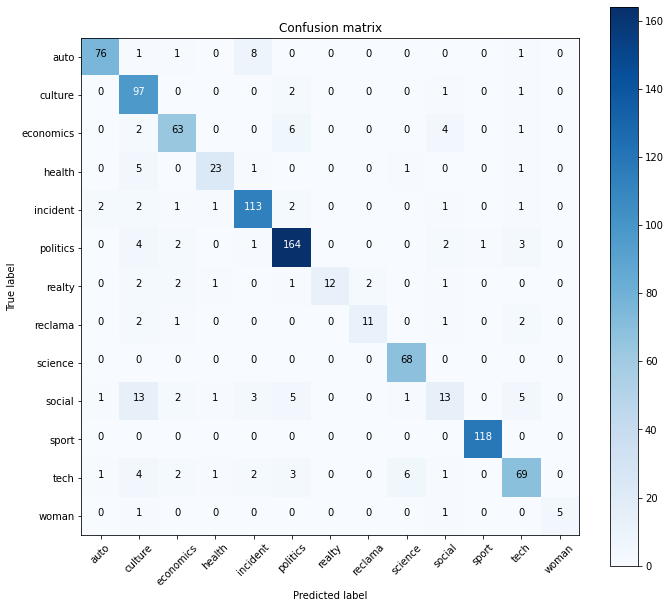

In [23]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [24]:
o = clf.predict(X)

In [25]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [26]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: economics
predict: tech
Официально: velcom покупает "Атлант Телеком" 30 ноября 2016 в 10:29 Дмитрий Смирнов / Александр Заяц / 42.TUT.BY Оператор сотовой связи velcom объявил о покупке компании «Атлант Телеком». Эту инфор...
- - - - - - - - - - - - - - - - - -
tag: science
predict: science
10:21 - 13.12.2016 Американской компании потребуется больше времени для оценки систем запуска ракеты. Компания Илона Маска SpaceX перенесла запуск пилотируемых капсул к Международной космической ста...
- - - - - - - - - - - - - - - - - -
tag: social
predict: social
Погода в Гродно и области в выходные: не по-зимнему тепло, но дождливо и облачно 9 декабря 2016 в 9:49 TUT.BY Совсем не зимняя погода ожидает жителей региона в этот уикенд. В выходные будет тепло —...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
ИА SAKH.COM (Южно-Сахалинск) На соревнованиях по национальным видам
спорта в Некрасовке Ногликский район был представлен двумя командами В селе
Некрасовка прошли шестые соревн

In [27]:
# https://habr.com/ru/post/205360/